#### 队列

FIFO(First IN First OUT)

* 用数组实现的队列叫作顺序队列
* 用链表实现的队列叫作链式队列。

##### 应用
循环队列、阻塞队列、并发队列。

它们在很多偏底层系统、框架、中间件的开发中，起着关键性的作用。

比如高性能队列 Disruptor、Linux 环形缓存，都用到了循环并发队列；Java concurrent 并发包利用 ArrayBlockingQueue 来实现公平锁等。


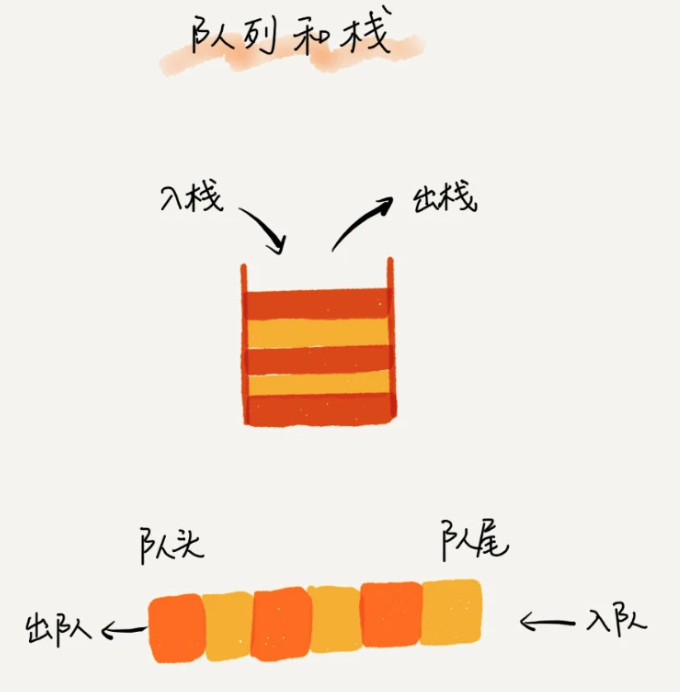


##### FAQ

线程池没有空闲线程时，新的任务请求线程资源时，线程池该如何处理？各种处理策略又是如何实现的呢？
* 第一种是非阻塞的处理方式，直接拒绝任务请求；
* 另一种是阻塞的处理方式，将请求排队，等到有空闲线程时，取出排队的请求继续处理


那如何存储排队的请求呢？
* 我们希望公平地处理每个排队的请求，先进者先服务，所以队列这种数据结构很适合来存储排队请求


队列有基于链表和基于数组这两种实现方式。这两种实现方式对于排队请求又有什么区别呢？
* 基于链表的实现方式，可以实现一个支持无限排队的无界队列（unbounded queue），但是可能会导致过多的请求排队等待，请求处理的响应时间过长。所以，针对响应时间比较敏感的系统，基于链表实现的无限排队的线程池是不合适的。
* 基于数组实现的有界队列（bounded queue），队列的大小有限，所以线程池中排队的请求超过队列大小时，接下来的请求就会被拒绝，这种方式对响应时间敏感的系统来说，就相对更加合理。不过，设置一个合理的队列大小，也是非常有讲究的。队列太大导致等待的请求太多，队列太小会导致无法充分利用系统资源、发挥最大性能。


除了前面讲到队列应用在`线程池请求排队`的场景之外，队列可以应用在任何有限资源池中，用于排队请求，比如`数据库连接池`等。实际上，对于大部分资源有限的场景，当没有空闲资源时，基本上都可以通过“队列”这种数据结构来实现请求排队。


##### 顺序队列时间复杂度

1. 入队 O(1)
2. 出队 O(n) -> O(1)
   1. 每次出队都进行数据迁移的话，每次都是O(n)
   2. 将数据迁移优化到入队时进行操作，只有在tail=n时，才需要进行数据迁移。迁移的时间复杂度为O(n)，平摊到每次操作上即为 O(1)

~~~
// 用数组实现的队列
public class ArrayQueue {
  // 数组：items，数组大小：n
  private String[] items;
  private int n = 0;
  // head表示队头下标，tail表示队尾下标
  private int head = 0;
  private int tail = 0;

  // 申请一个大小为capacity的数组
  public ArrayQueue(int capacity) {
    items = new String[capacity];
    n = capacity;
  }

  // 入队
  public boolean enqueue(String item) {
    // 如果tail == n 表示队列已经满了
    if (tail == n) return false;
    items[tail] = item;
    ++tail;
    return true;
  }

  // 出队
  public String dequeue() {
    // 如果head == tail 表示队列为空
    if (head == tail) return null;
    // 为了让其他语言的同学看的更加明确，把--操作放到单独一行来写了
    String ret = items[head];
    ++head;
    return ret;
  }
}
~~~


##### 数据迁移的优化

~~~

   // 入队操作，将item放入队尾
  public boolean enqueue(String item) {
    // tail == n表示队列末尾没有空间了
    if (tail == n) {
      // tail ==n && head==0，表示整个队列都占满了
      if (head == 0) return false;
      // 数据搬移
      for (int i = head; i < tail; ++i) {
        items[i-head] = items[i];
      }
      // 搬移完之后重新更新head和tail
      tail -= head;
      head = 0;
    }
    
    items[tail] = item;
    ++tail;
    return true;
  }
~~~

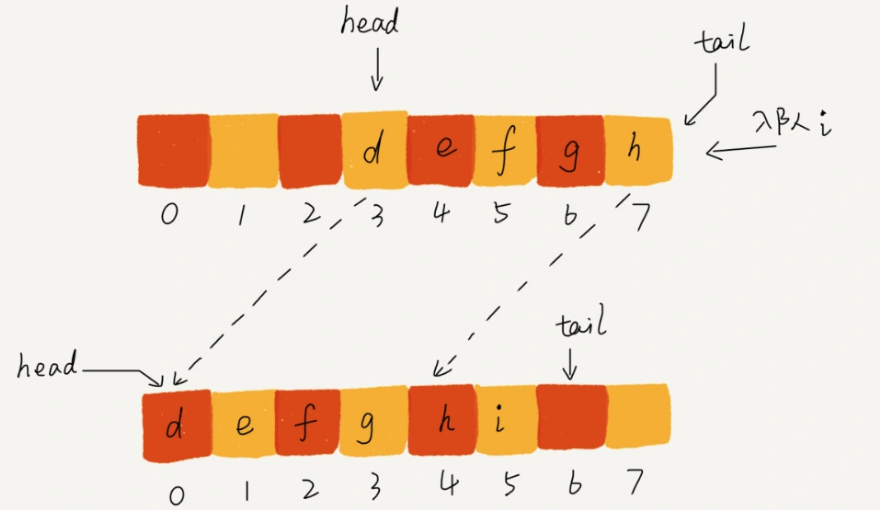

##### 循环队列

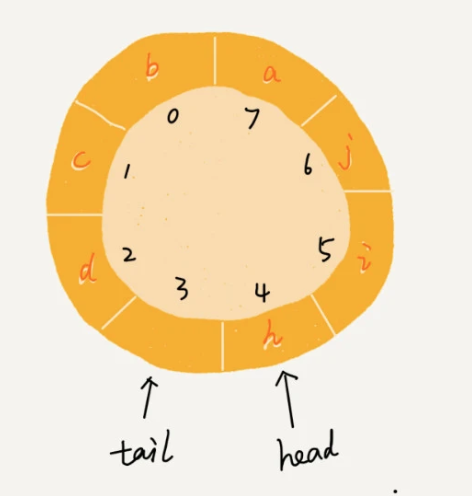

```
public class CircularQueue {
  // 数组：items，数组大小：n
  private String[] items;
  private int n = 0;
  // head表示队头下标，tail表示队尾下标
  private int head = 0;
  private int tail = 0;

  // 申请一个大小为capacity的数组
  public CircularQueue(int capacity) {
    items = new String[capacity];
    n = capacity;
  }

  // 入队
  public boolean enqueue(String item) {
    // 队列满了
    if ((tail + 1) % n == head) return false;
    items[tail] = item;
    tail = (tail + 1) % n;
    return true;
  }

  // 出队
  public String dequeue() {
    // 如果head == tail 表示队列为空
    if (head == tail) return null;
    String ret = items[head];
    head = (head + 1) % n;
    return ret;
  }
}
```



##### 阻塞队列

阻塞队列其实就是在队列基础上增加了阻塞操作。
简单来说，就是在队列为空的时候，从队头取数据会被阻塞
* 因为此时还没有数据可取，直到队列中有了数据才能返回；
* 如果队列已经满了，那么插入数据的操作就会被阻塞，直到队列中有空闲位置后再插入数据，然后再返回。

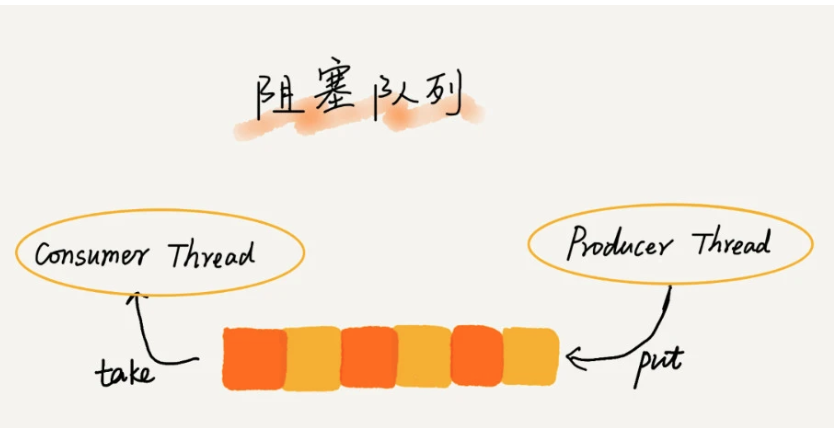

一个“生产者 - 消费者模型”

种基于阻塞队列实现的“生产者 - 消费者模型”，可以有效地协调生产和消费的速度。当“生产者”生产数据的速度过快，“消费者”来不及消费时，存储数据的队列很快就会满了。这个时候，生产者就阻塞等待，直到“消费者”消费了数据，“生产者”才会被唤醒继续“生产”。

而且不仅如此，基于阻塞队列，我们还可以通过协调“生产者”和“消费者”的个数，来提高数据的处理效率。比如前面的例子，我们可以多配置几个“消费者”，来应对一个“生产者”。

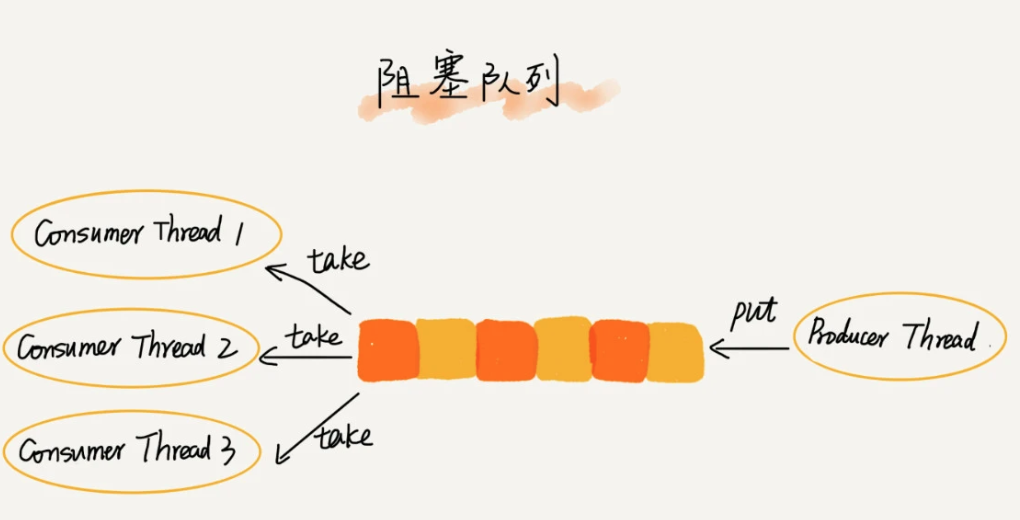




##### 并发队列

面我们讲了阻塞队列，在多线程情况下，会有多个线程同时操作队列，这个时候就会存在线程安全问题，那如何实现一个线程安全的队列呢？

线程安全的队列我们叫作并发队列。
* 最简单直接的实现方式是直接在 enqueue()、dequeue() 方法上加锁
* 但是锁粒度大并发度会比较低
* 同一时刻仅允许一个存或者取操作。
* 实际上，基于数组的循环队列，利用 CAS 原子操作，可以实现非常高效的并发队列。这也是循环队列比链式队列应用更加广泛的原因。
在实战篇讲 Disruptor 的时候，我会再详细讲并发队列的应

